✅ Setup terminé!
Version XGBoost: 2.1.4
📊 Chargement des données...
Shape du dataset: (284807, 31)
Colonnes: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Taux de fraude: 0.0017 (492 fraudes sur 284807 transactions)

🔍 Aperçu des données:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ..

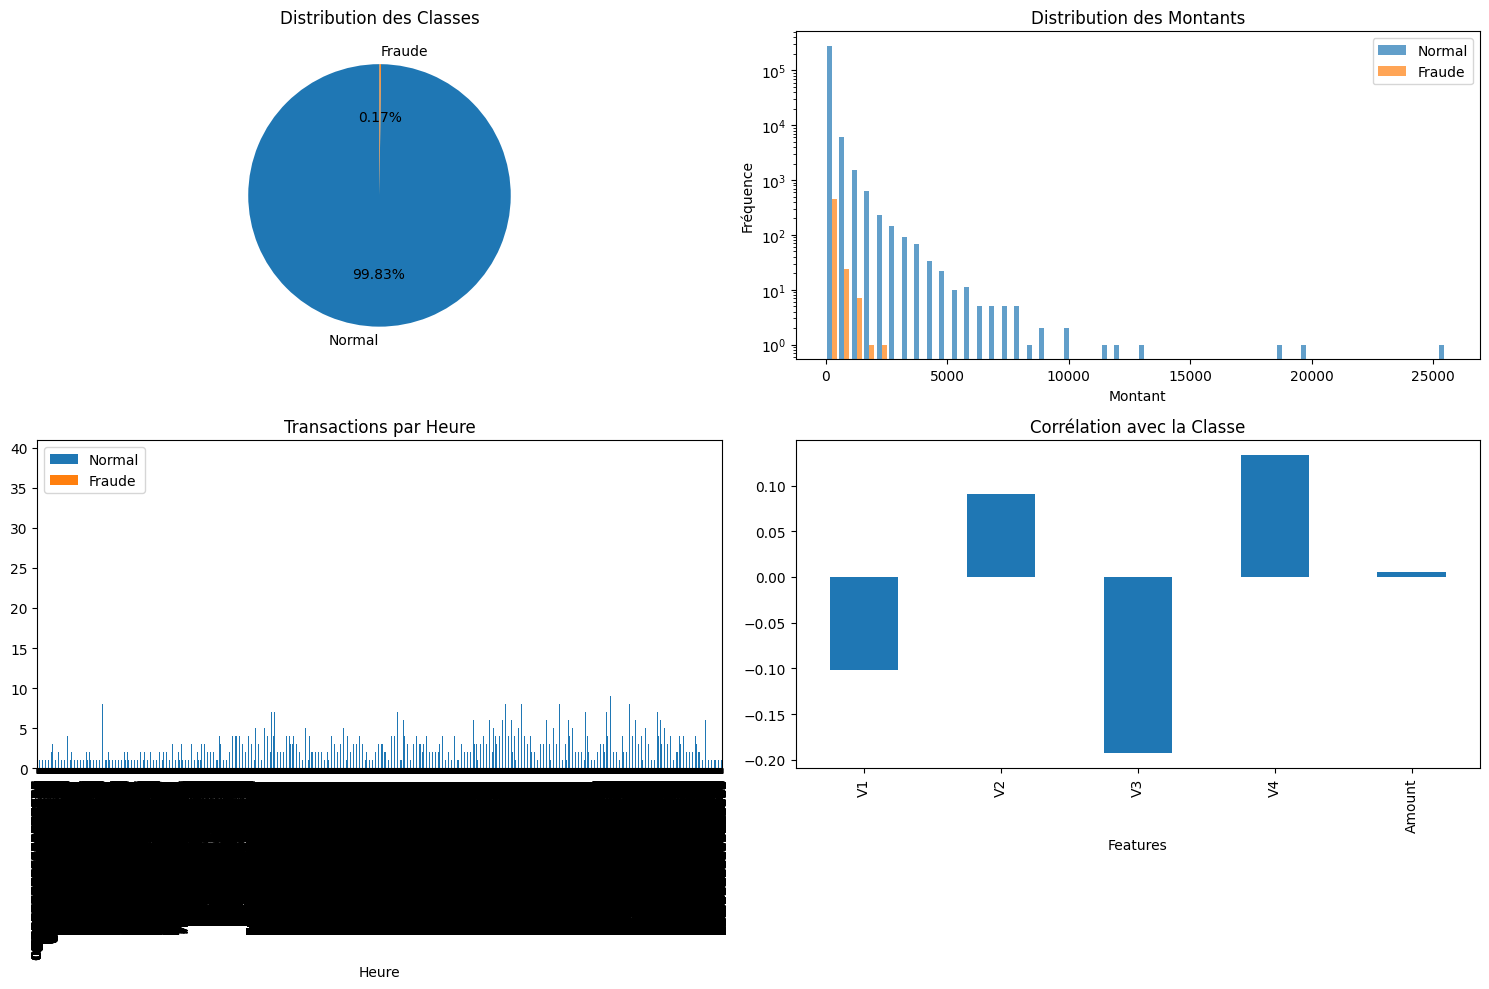


📊 Statistiques par classe:
Transactions normales:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Transactions frauduleuses:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
🔧 Feature Engineering
✅ Features créées! Shape finale: (284807, 37)
Nouvelles features: ['Day', 'Amount_log', 'Amount_scaled', 'V1_V2_interaction', 'V1_Amount_interaction', 'Amount_rolling_mean', 'Amount_rolling_std']
📋 Préparation des données pour ML
Training set: (227845, 37), Fraudes: 417
Test set: (56962, 37), Fraudes: 75
🤖 Entraînement du modèle Isolation Forest
🚀 Entraînement du modèle XGBoost avec SMOTE
📊 Évaluation des modèles
AUC-ROC: 0.9837

Classification Report:
              precision    recal

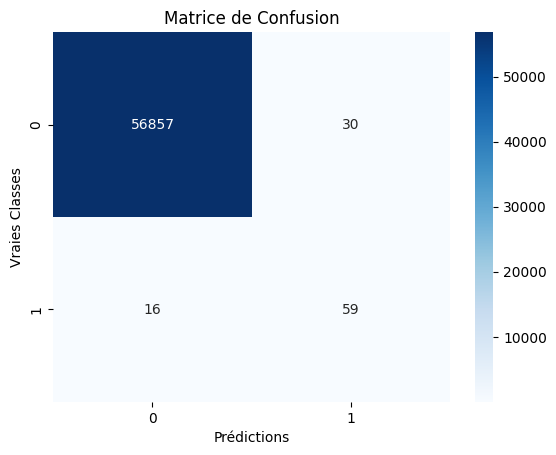


✅ Modèle prêt pour déploiement!


In [5]:
# =====================================================
# DÉTECTION DE FRAUDES BANCAIRES - GOOGLE COLAB
# Solution Complète avec Simulation Temps Réel
# VERSION OPTIMISÉE - XGBoost et Isolation Forest
# =====================================================

# =============================================================================
# CELLULE 1: SETUP ET INSTALLATION
# =============================================================================

# Installation des packages nécessaires
!pip install -q xgboost imbalanced-learn plotly pyngrok shap

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb

# Autres
import warnings
warnings.filterwarnings('ignore')
import time
import json

print("✅ Setup terminé!")
print(f"Version XGBoost: {xgb.__version__}")

# =============================================================================
# CELLULE 2: TÉLÉCHARGEMENT ET CHARGEMENT DES DONNÉES
# =============================================================================

# Télécharger le dataset
!wget -q https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv

# Charger les données
print("📊 Chargement des données...")
df = pd.read_csv('creditcard.csv')

print(f"Shape du dataset: {df.shape}")
print(f"Colonnes: {list(df.columns)}")
print(f"Taux de fraude: {df['Class'].mean():.4f} ({df['Class'].sum()} fraudes sur {len(df)} transactions)")

# Aperçu des données
print("\n🔍 Aperçu des données:")
print(df.head())
print(f"\nInformations sur les données:")
print(df.info())

# =============================================================================
# CELLULE 3: ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# =============================================================================

print("📈 Analyse Exploratoire des Données")

# Configuration des graphiques
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution des classes
axes[0,0].pie([df['Class'].value_counts()[0], df['Class'].value_counts()[1]],
              labels=['Normal', 'Fraude'], autopct='%1.2f%%', startangle=90)
axes[0,0].set_title('Distribution des Classes')

# 2. Distribution des montants
axes[0,1].hist([df[df['Class']==0]['Amount'], df[df['Class']==1]['Amount']],
               bins=50, alpha=0.7, label=['Normal', 'Fraude'])
axes[0,1].set_xlabel('Montant')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].set_title('Distribution des Montants')
axes[0,1].legend()
axes[0,1].set_yscale('log')

# 3. Transactions par heure
df['Hour'] = (df['Time'] / 3600) % 24
hour_fraud = df.groupby(['Hour', 'Class']).size().unstack(fill_value=0)
hour_fraud.plot(kind='bar', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Transactions par Heure')
axes[1,0].set_xlabel('Heure')
axes[1,0].legend(['Normal', 'Fraude'])

# 4. Corrélation avec quelques features V
features_to_plot = ['V1', 'V2', 'V3', 'V4', 'Amount']
correlation_with_class = df[features_to_plot + ['Class']].corr()['Class'].drop('Class')
correlation_with_class.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Corrélation avec la Classe')
axes[1,1].set_xlabel('Features')

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\n📊 Statistiques par classe:")
print("Transactions normales:")
print(df[df['Class']==0]['Amount'].describe())
print("\nTransactions frauduleuses:")
print(df[df['Class']==1]['Amount'].describe())

# =============================================================================
# CELLULE 4: FEATURE ENGINEERING
# =============================================================================

print("🔧 Feature Engineering")

# Créer une copie pour le feature engineering
df_features = df.copy()

# 1. Features temporelles
df_features['Hour'] = (df_features['Time'] / 3600) % 24
df_features['Day'] = (df_features['Time'] / (3600 * 24)) % 7

# 2. Transformation des montants
df_features['Amount_log'] = np.log1p(df_features['Amount'])

# Normaliser le montant
scaler = StandardScaler()
df_features['Amount_scaled'] = scaler.fit_transform(df_features[['Amount']])

# 3. Features d'interaction
df_features['V1_V2_interaction'] = df_features['V1'] * df_features['V2']
df_features['V1_Amount_interaction'] = df_features['V1'] * df_features['Amount_scaled']

# 4. Moyennes mobiles simulées
df_features = df_features.sort_values('Time')
df_features['Amount_rolling_mean'] = df_features['Amount'].rolling(window=100, min_periods=1).mean()
df_features['Amount_rolling_std'] = df_features['Amount'].rolling(window=100, min_periods=1).std()

# Créer le dataset final pour ML
feature_columns = [f'V{i}' for i in range(1, 29)] + [
    'Amount', 'Hour', 'Day', 'Amount_log', 'Amount_scaled',
    'V1_V2_interaction', 'V1_Amount_interaction',
    'Amount_rolling_mean', 'Amount_rolling_std'
]

X = df_features[feature_columns].fillna(0)  # Remplir les NaN des rolling stats
y = df_features['Class']

print(f"✅ Features créées! Shape finale: {X.shape}")
print(f"Nouvelles features: {[col for col in feature_columns if col not in df.columns]}")

# =============================================================================
# CELLULE 5: PRÉPARATION DES DONNÉES POUR ML
# =============================================================================

print("📋 Préparation des données pour ML")

# Split temporel (pas de shuffle pour garder l'ordre temporel)
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training set: {X_train.shape}, Fraudes: {y_train.sum()}")
print(f"Test set: {X_test.shape}, Fraudes: {y_test.sum()}")

# =============================================================================
# CELLULE 6: ENTRAÎNEMENT DU MODÈLE DE DÉTECTION D'ANOMALIES
# =============================================================================

print("🤖 Entraînement du modèle Isolation Forest")

# Isolation Forest
isolation_forest = IsolationForest(
    contamination=0.002,  # Estimation des anomalies
    random_state=42,
    n_jobs=-1
)

isolation_forest.fit(X_train)

# =============================================================================
# CELLULE 7: ENTRAÎNEMENT DU MODÈLE XGBOOST
# =============================================================================

print("🚀 Entraînement du modèle XGBoost avec SMOTE")

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_balanced, y_balanced)

# =============================================================================
# CELLULE 8: ÉVALUATION DES MODÈLES
# =============================================================================

print("📊 Évaluation des modèles")

# Prédictions XGBoost
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Métriques
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel('Prédictions')
plt.ylabel('Vraies Classes')
plt.show()

print("\n✅ Modèle prêt pour déploiement!")